# Executive summary

**Objective:** Develop a model to predict whether a tweet contains information about a real disaster or not. (it's not a clickbait or it is).

2. The LSTM model proved to be the most stable when using input data provided by a GloVe vectorizer.

3. The model achieved an F1 score of 0.75 on the test dataset (see leaderboard).

4. Despite this, deeper analysis indicates that the model still underperforms. Alternative strategies may be required.

**NOTE:**
* I have reused some parts of the Unsupervised Algorithms Final Project and the Supervised Algorithms Final Project.
* The detailed code mechanism is presented in the report (Report - full)

# Plan

1. Dataset description
2. Cleaning dataset
3. Dataset stats
4. Vocab analysis
5. Ngram analysis
6. Other features
7. TFiDF launch
9. Hyperparameter search - phase I - 550-s Runs on A1000
10. Hyperparameter search - final model - LSTM
11. Conclusion

# Libraries

In [1]:
# Libraries

import sys

import nltk
from pandarallel import pandarallel

nltk.download('wordnet')
import pickle
import sys
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from torch import nn

sys.path.append("..")
from constant import (COLUMN_WITH_TEXT, MAPPING_OVERALL_TO_SENTIMENT,
                      MAPPING_SENTIMENT_TO_NUMBER)
from flashtext import KeywordProcessor
from sklearn.metrics import f1_score
from torch import nn

nltk.download("wordnet")
import os
import re
import string
import sys
import time
from dataclasses import dataclass
from glob import glob

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import xgboost as xgb
from collections import Counter
from data_preprocessors.correction_heuristics_executor import \
    CorrectionHeuristicsExecutor
from data_preprocessors.data_cleaner import DataCleaner
from data_preprocessors.spacy_analyzer import SpacyAnalyzer
from nltk.corpus import stopwords
from pandarallel import pandarallel
from pandas import json_normalize
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from tqdm.autonotebook import tqdm, trange

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)


pandarallel.initialize(progress_bar=True, nb_workers=10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_62649/2146245918.py:59: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
08-17 12:58 git.cmd      DEBUG    Popen(['git', 'version'], cwd=/workspace/disaster-tweet/notebooks, stdin=None, shell=False, universal_newlines=False)
08-17 12:58 git.cmd      DEBUG    Popen(['git', 'version'], cwd=/workspace/disaster-tweet/notebooks, stdin=None, shell=False, universal_newlines=False)
08-17 12:58 wandb.docker.auth DEBUG    Trying paths: ['/root/.docker/config.json', '/root/.dockercfg']
08-17 12:58 wa

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# About dataset

In this competition, the objective is to develop a machine learning model capable of distinguishing between tweets related to real disasters and those that are not. A dataset containing 10,000 manually classified tweets is provided.

In [9]:
# !rm -R ../data

!mkdir -p  ../data

In [10]:

train_data = pd.read_csv(
    "../data/train.csv",
)

In [11]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# Cleaning training data

In order to get cleaner text (without typos and unknown words), I have:
- removed duplicated punctuations,
- converted emojis to the word equivalents (e.g. kiss mark),
- removed unknown words from pov of wordnet, 
- removed characters that occur more than 2 times consequtively, 
- converted compound words that are mistakenly written into separate words
etc. 


In [12]:
!rm -R train_spans # clean up resources

rm: cannot remove 'train_spans': No such file or directory


For this exercise I used SpacyAnalyzer processor, as well as custom CorrectionHeuristicsExecutor. This entire sequence is about reducing effect of typos and misclicks on the quality of the data (I used i.a. Viterbi algorithm).

In [13]:
data_cleaner = DataCleaner(train_data)
data_cleaner.preprocess()
data_cleaner.data = data_cleaner.data[
    ~(data_cleaner.data[COLUMN_WITH_TEXT] == "")
].reset_index(drop=True)

08-17 06:04 data_preprocessors.data_cleaner INFO     Words that are uppercase are converted to lowercase


08-17 06:04 data_preprocessors.data_cleaner INFO     Contraction converted to two words sequences


08-17 06:04 data_preprocessors.data_cleaner INFO     HTML characters dropped


08-17 06:04 data_preprocessors.data_cleaner INFO     Emojis dropped


08-17 06:04 data_preprocessors.data_cleaner INFO     Duplicate punctuation removed


08-17 06:04 data_preprocessors.data_cleaner INFO     Removed more than 3 consecutive same characters


08-17 06:04 data_preprocessors.data_cleaner INFO     Add space after punctuation


08-17 06:04 data_preprocessors.data_cleaner INFO     Duplicate spaces removed
08-17 06:04 data_preprocessors.data_cleaner INFO     Cleaning process ended


In [14]:
data_cleaner.data.to_csv("../data//_train_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_train_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="train_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

08-17 06:04 data_preprocessors.spacy_analyzer INFO     Spacy analysis started
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.07s/it]
08-17 06:04 data_preprocessors.spacy_analyzer INFO     Spacy analysis ended
08-17 06:04 data_preprocessors.correction_heuristics_executor INFO     Words will be corrected into known words or removed
100%|████████████████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 22681.71it/s]
08-17 06:04 data_preprocessors.correction_heuristics_executor INFO     Pipeline ended


In [15]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [16]:
data["cleaned sentences"] = texts

In [17]:
len(new_texts)

7613

In [18]:
data.shape

(7613, 6)

In [19]:
data["text_lematized"] = new_texts

In [20]:
data["length"] = train_data[COLUMN_WITH_TEXT].str.len()

In [22]:
data.reset_index(drop=True).to_csv("../data/final_train_data.csv")

# Short overview

In [74]:
train_data.describe()

,Unnamed: 0,id,target,length,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,lengths
count,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000
mean,2165.000000,5434.745786,0.483722,127.764950,127.764950,0.130686,0.127453,2.701916,0.096052,22.655045
std,1250.396337,3072.135952,0.499793,13.027194,13.027194,0.420060,0.428663,1.769394,0.348551,3.420582
min,0.000000,5.000000,0.000000,101.000000,101.000000,0.000000,0.000000,0.000000,0.000000,12.000000
25%,1082.500000,2910.500000,0.000000,117.000000,117.000000,0.000000,0.000000,2.000000,0.000000,20.000000
50%,2165.000000,5373.000000,0.000000,132.000000,132.000000,0.000000,0.000000,3.000000,0.000000,23.000000
75%,3247.500000,7979.000000,1.000000,138.000000,138.000000,0.000000,0.000000,4.000000,0.000000,25.000000
max,4330.000000,10872.000000,1.000000,154.000000,154.000000,4.000000,10.000000,24.000000,3.000000,38.000000


Cleaned training data contains unique 4248 tweets.

In [25]:
train_data = pd.read_csv("../data/final_train_data.csv")

In [75]:
len(train_data[COLUMN_WITH_TEXT].unique())

4248

In [76]:
print(
    train_data[
        train_data[COLUMN_WITH_TEXT].str.len() == train_data[COLUMN_WITH_TEXT].str.len().max()
    ][COLUMN_WITH_TEXT].values[0][:1000]
)

ig: http: t. co/ 2wbivkzjip ' it' s hailing again! # abstorm # yyc # hail # hailstorm # haildamage # yycweather # calgary # captureyyc # alberta # stoÛ_ 


In [29]:
try:
    print(train_data[train_data[COLUMN_WITH_TEXT].str.len() < 100][COLUMN_WITH_TEXT].values[0][:1000])
except:
    pass

08-17 17:04 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08-17 17:04 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


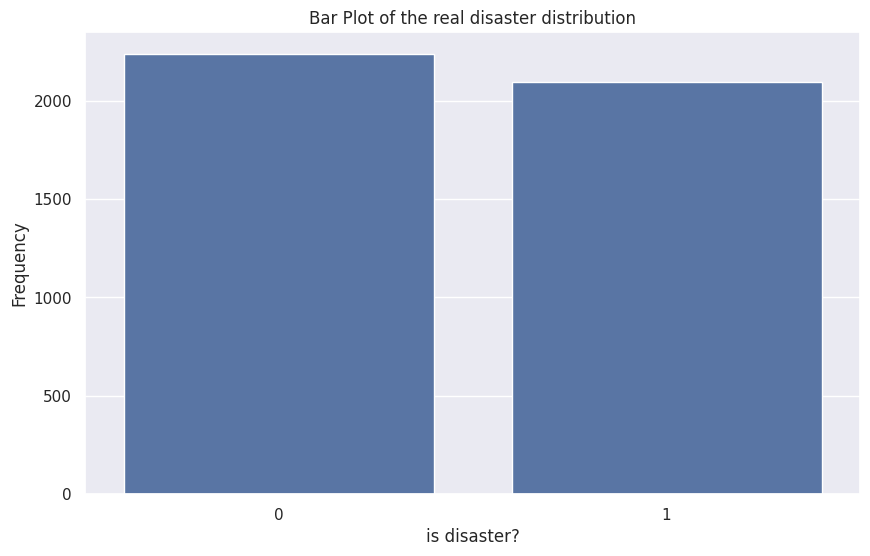

In [78]:
plt.figure(figsize=(10, 6))
ordered_overall = sorted(train_data["target"].fillna(3.0).unique())
sns.countplot(x="target", data=train_data, order=ordered_overall)

plt.title("Bar Plot of the real disaster distribution")
plt.xlabel("is disaster?")
plt.ylabel("Frequency")
plt.show()

# Vocab analysis

Analysis of vocabulary from a part of speech perspective might be useful, especially if we would like to examine how the text of a typical tweet  is constructed.

In [57]:
analyzer = SpacyAnalyzer(
    path_to_data="../data/final_train_data.csv",
    chunk_size=len(data),
    destination_folder="train_spans/",
)


In [58]:
poses = analyzer.collect_info_about_words("pos")

pos
['train_spans/spacy_info_0']


<Axes: ylabel='Frequency'>

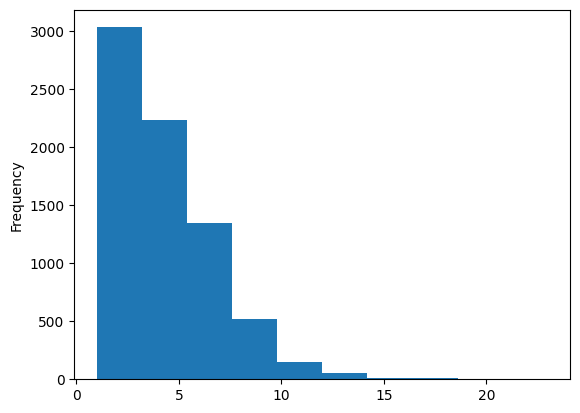

In [64]:
counted_poses = [
    Counter([word[1] for sentence in sequence for word in sentence])
    for sequence in poses
]

counted_poses = [dict(count) for count in counted_poses]


poses_matrix = pd.DataFrame(counted_poses)

poses_matrix["NOUN"].plot.hist()

In [65]:
noun_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "NOUN"
]
verb_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "VERB"
]
adjective_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "ADJ"
]

In [66]:
noun_occurences = Counter(noun_occurences)

In [67]:
results = sorted(dict(noun_occurences), key=lambda x: noun_occurences[x], reverse=True)
{key: noun_occurences[key] for key in results[:30]}

{'#': 3135,
 'http': 2331,
 'https': 227,
 'fire': 184,
 'people': 176,
 'video': 141,
 'news': 114,
 'disaster': 111,
 's': 104,
 'time': 102,
 '|': 101,
 'buildings': 99,
 'day': 98,
 'fires': 87,
 '_': 87,
 'bomb': 87,
 'body': 84,
 'suicide': 81,
 'crash': 80,
 'life': 80,
 'emergency': 79,
 'pm': 79,
 'today': 79,
 'car': 78,
 'police': 78,
 'storm': 76,
 'way': 71,
 'train': 71,
 'accident': 68,
 'attack': 67}

In [68]:
verb_occurences = Counter(verb_occurences)

In [69]:
results = sorted(dict(verb_occurences), key=lambda x: verb_occurences[x], reverse=True)
{key: verb_occurences[key] for key in results[:30]}

{'s': 248,
 'have': 200,
 'get': 135,
 'http': 129,
 'know': 108,
 'going': 96,
 'burning': 93,
 'killed': 91,
 'do': 90,
 'go': 89,
 'see': 88,
 'think': 83,
 'had': 82,
 'got': 79,
 "'": 77,
 'want': 75,
 'say': 73,
 'let': 73,
 'has': 60,
 'need': 60,
 'make': 59,
 'said': 57,
 'love': 55,
 'feel': 51,
 'come': 50,
 'injured': 49,
 'm': 48,
 'take': 48,
 'help': 47,
 'hit': 46}

In [70]:
adjective_occurences = Counter(adjective_occurences)

In [71]:
results = sorted(
    dict(adjective_occurences), key=lambda x: adjective_occurences[x], reverse=True
)
selected_results = {key: adjective_occurences[key] for key in results[:50]}

In [72]:
selected_results

{'new': 122,
 'more': 90,
 'old': 89,
 'many': 71,
 'nuclear': 71,
 'good': 70,
 'More': 70,
 'dead': 67,
 'first': 65,
 'last': 63,
 'fatal': 61,
 'hot': 55,
 'great': 45,
 'Full': 45,
 'little': 42,
 'bad': 40,
 'New': 40,
 'black': 40,
 'whole': 38,
 'natural': 38,
 'other': 36,
 'loud': 36,
 'structural': 36,
 'Latest': 34,
 'best': 32,
 'bloody': 31,
 'wild': 31,
 'high': 31,
 'real': 31,
 'pkk': 31,
 'military': 31,
 'horrible': 30,
 'big': 30,
 'much': 29,
 'next': 29,
 'free': 29,
 'mass': 29,
 'few': 28,
 'same': 28,
 'atomic': 28,
 '16yr': 28,
 'cool': 26,
 'least': 26,
 'possible': 26,
 'violent': 26,
 'Saudi': 26,
 'Israeli': 26,
 'sure': 25,
 'beautiful': 25,
 'bigger': 25}

Definitely, some words should be removed because they do not indicate any specific topic and could reduce the effectiveness of the TF-IDF vectorizer.

# Vocabulary analysis per ngram and target type. 

Let's analyse corpus for distribution of most common "figurative" n-grams.

## Disaster tweet ngrams

In [73]:
@dataclass
class VectorizerData:
    ngram: int
    sentiment: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [74]:
with open("stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

In [80]:
def get_top_ngram(sentiment, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    bag_of_words = vectorizer.fit_transform(
        train_data[train_data.target == sentiment]["text"]
    )
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return VectorizerData(
        ngram=n,
        sentiment=sentiment,
        vectorizer=vectorizer,
        sum_words=sum_words,
        words_freq=words_freq,
    )

In [85]:
positive_1_gram = get_top_ngram(1, 1)

<Axes: >

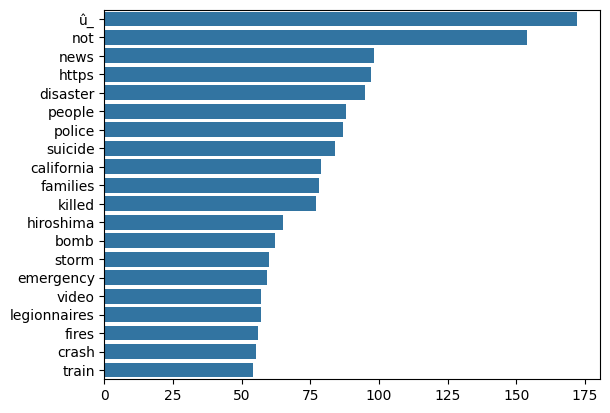

In [86]:
x, y = map(list, zip(*positive_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [87]:
positive_2_gram = get_top_ngram(1, 2)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

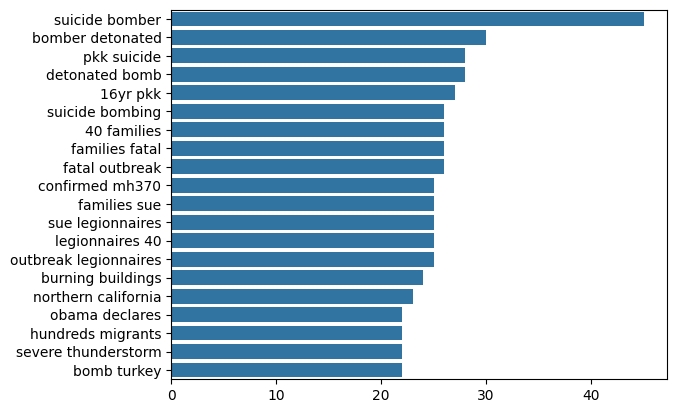

In [88]:
x, y = map(list, zip(*positive_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [90]:
positive_3_gram = get_top_ngram(1, 3)

<Axes: >

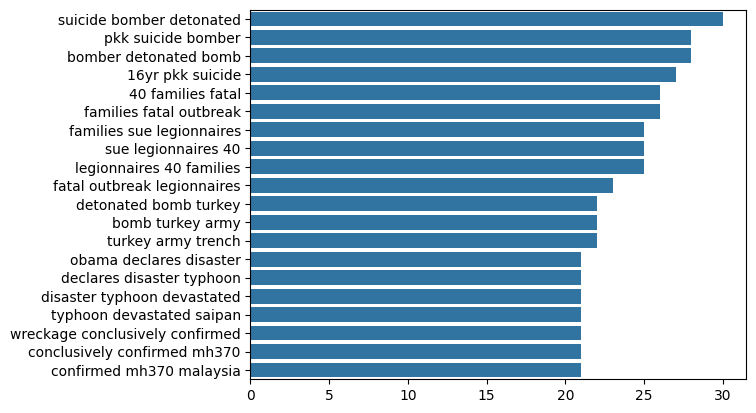

In [91]:
x, y = map(list, zip(*positive_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## non-disaster tweets ngrams

In [92]:
negative_1_gram = get_top_ngram(0, 1)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

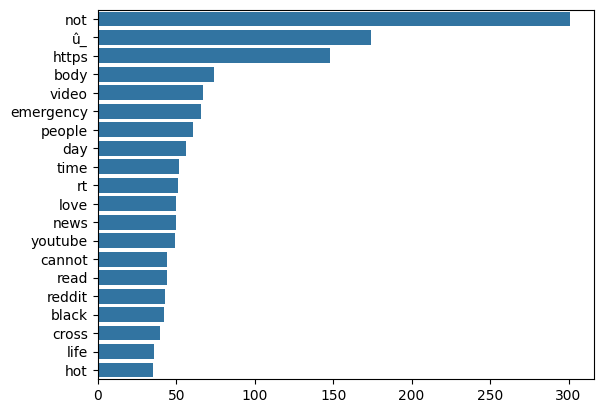

In [93]:
x, y = map(list, zip(*negative_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [94]:
negative_2_gram = get_top_ngram(0, 2)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

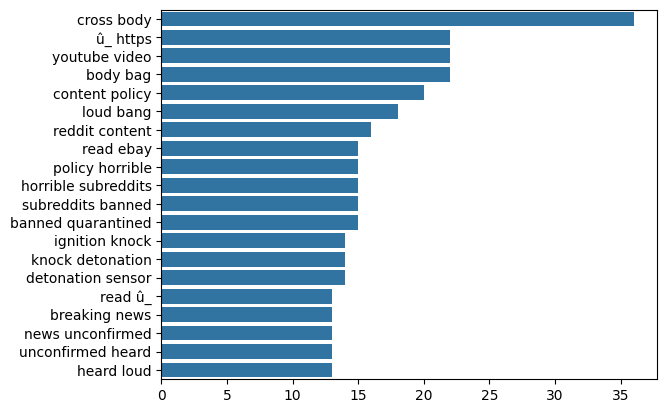

In [95]:
x, y = map(list, zip(*negative_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [96]:
negative_3_gram = get_top_ngram(0, 3)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

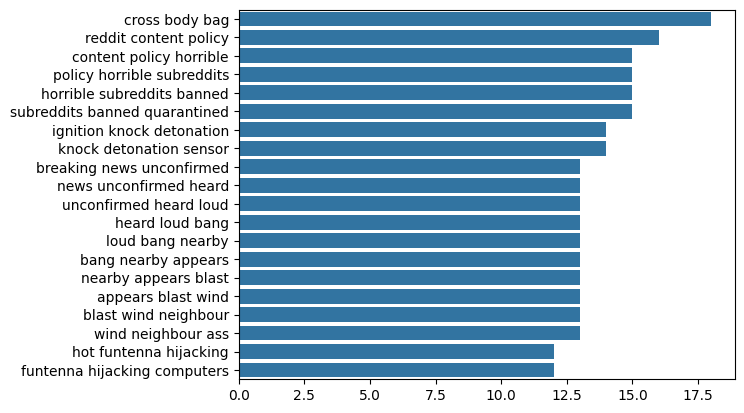

In [97]:
x, y = map(list, zip(*negative_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

# Other features

In [99]:
train_data["total_length"] = train_data[COLUMN_WITH_TEXT].apply(lambda x: len(x))
train_data["num_exclamation_marks"] = train_data[COLUMN_WITH_TEXT].apply(
    lambda comment: comment.count("!")
)
train_data["num_question_marks"] = train_data[COLUMN_WITH_TEXT].apply(
    lambda comment: comment.count("?")
)
train_data["num_punctuation"] = train_data[COLUMN_WITH_TEXT].apply(
    lambda comment: sum(comment.count(w) for w in ".,;:")
)
train_data["num_symbols"] = train_data[COLUMN_WITH_TEXT].apply(
    lambda comment: sum(comment.count(w) for w in "*&$%")
)

In [102]:
corr = train_data[
    [
        "total_length",
        "num_exclamation_marks",
        "num_question_marks",
        "num_punctuation",
        "num_symbols",
        "target",
    ]
].corr()

08-17 06:12 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd0e3487040>


<Axes: >

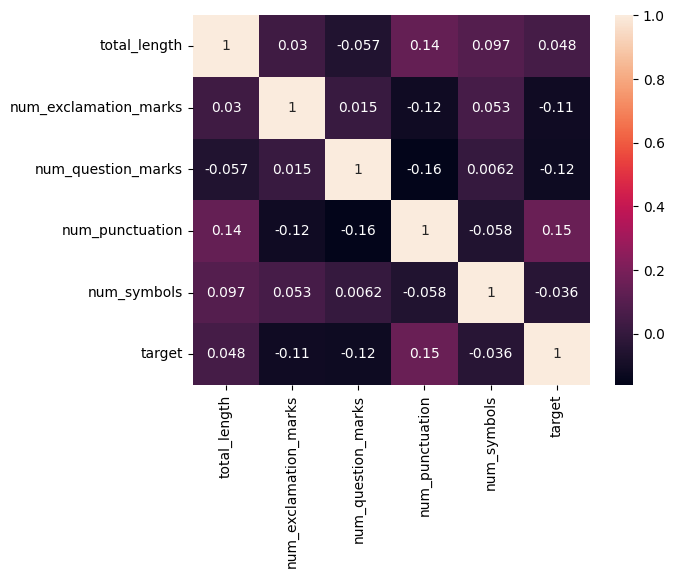

In [103]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

We can see that these features are not correlated with the mapped sentiment, which means we can remove them from the analysis.

Source of idea: https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

# Lengths

Most of the reviews are between 0 and 40 characters in length. This is somewhat unexpected, given that tweets at that time were 140 characters long.

In [79]:
lengths = train_data[COLUMN_WITH_TEXT].apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

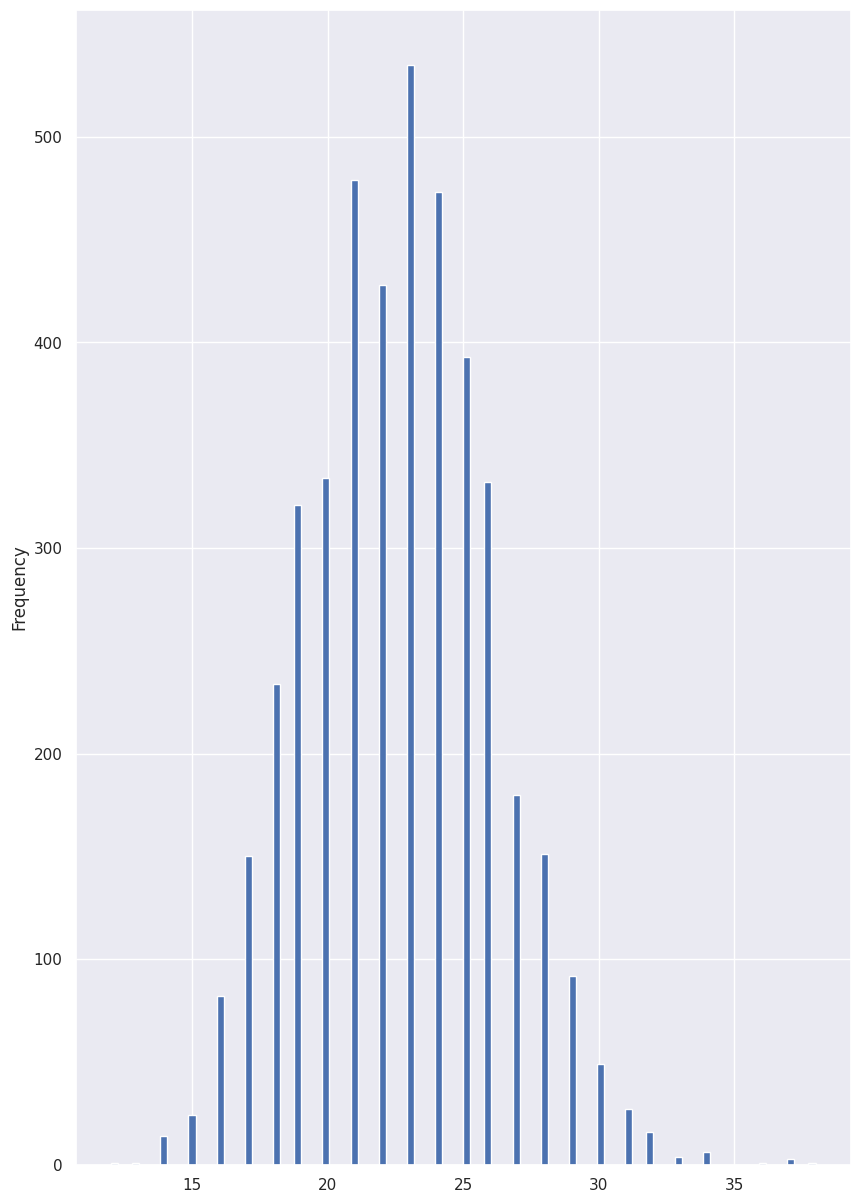

In [80]:
lengths.plot.hist(bins=100)

In [81]:
train_data["lengths"] = lengths

In [82]:
train_data = train_data[train_data["lengths"] < 1000].reset_index(drop=True)

In [83]:
train_data = train_data[
    (1000 > train_data["lengths"]) & (train_data["lengths"] > 10)
].reset_index(drop=True)

In [84]:
train_data.to_csv("../data/final_train_data.csv")

# KFold analysis

I will use K-fold in order to fin d the most stable model. K-fold cross-validation is a reliable and efficient technique for evaluating and validating machine learning models. It reduces bias and variance associated with a single training/test split by dividing the data into k equally sized folds and performing k iterations of training and testing. Each iteration uses a different fold as the test set while the remaining k-1 folds serve as the training set. This method ensures a robust assessment by averaging performance metrics over all iterations and makes efficient use of the dataset, especially when data is limited, as each data point is involved in both training and testing.

Additionally, k-fold cross-validation aids in better generalization of the model to unseen data, preventing overfitting, and plays a crucial role in the hyperparameter tuning process by evaluating different combinations of parameters to find the most optimal set. It offers reliable error estimates and aids in comparing different algorithms more accurately. This validation technique also provides higher assurance in model deployment by extensively testing performance, and helps in managing the bias-variance tradeoff, ensuring balanced model performance.

### Load data and build unique vocabulary for GloVE

I'll be using GloVe (Global Vectors for Word Representation) for embeddings. GloVe is a popular word embedding technique known for effectively capturing semantic relationships between words. Originating from researchers at Stanford, GloVe has been widely adopted in various natural language processing (NLP) tasks. They are better then TFiDF because GloVe embeddings are often considered more effective than TF-IDF for several reasons, especially in capturing the semantic relationships between words.

In [2]:
DATA_PATH = "../data/final_train_data.csv"
train_data = pd.read_csv(DATA_PATH, index_col=0)
unique_words = set(word for i in train_data['text_lematized'].str.split() for word in i)
unique_words = list(unique_words)
WORD2IX = {word : num for num, word in enumerate(unique_words)}

In [3]:
MAX_LENGTH = train_data['text_lematized'].str.split().apply(len).max()

In [4]:
def find_digits(input_string):
    pattern = r'\d+'
    
    matches = re.findall(pattern, input_string)[0]
    
    return int(matches)


In [5]:
data = train_data

In [6]:

df = pd.read_csv("../data/final_train_data.csv")
 
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for fold, (train_index, test_index) in enumerate(skf.split(X=df, y=df['target'])):
    train, test = df.iloc[train_index], df.iloc[test_index]
    train.to_csv(f"../data/train_fold_{fold}.csv")
    test.to_csv(f"../data/test_fold_{fold}.csv")

## Dataset definition

In [7]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        if self.labels is not None:
            label = self.labels[index]
            return text, label
        else:
            return text
        
def texts2tensor(texts,word2index,pad_token = 0,max_len = 50):
    indexes_list = [[word2index.get(word,0) for word in text.split()] for text in texts]
    max_len = min(max_len,max([len(indexes) for indexes in indexes_list]))
    truncated_indexes = [indexes[:max_len] for indexes in indexes_list]
    padded_indexes = [indexes+[0]*(max_len - len(indexes)) for indexes in truncated_indexes]
    return torch.LongTensor(padded_indexes)

def train_collate(batch_inputs):
    texts,labels = zip(*batch_inputs)
    input_tensor = texts2tensor(texts,WORD2IX)
    return input_tensor,torch.LongTensor(labels)


# Models architecture

The embeddings will be fed into RNN network (LSTM or GRU - depending on the results of the hyperparameter search. 

Recurrent Neural Networks (RNNs) are a specialized type of artificial neural network tailored for processing sequential data. Unlike feedforward neural networks, RNNs manage data across multiple time steps, making them well-suited for tasks such as text, speech, and time series analysis. The central component of RNNs is the recurrent unit, which maintains a hidden state—essentially a memory that is updated at each time step based on the current input and the previous hidden state. This mechanism enables the network to learn from historical data.

Early RNNs faced challenges with learning long-range dependencies due to the vanishing gradient problem. This issue was resolved with the introduction of Long Short-Term Memory (LSTM) networks in 1997, which have now become the standard for RNNs. RNNs find applications in various fields including handwriting recognition, speech recognition, natural language processing, and neural machine translation.

We will use:
1. LSTM - Traditional RNNs struggle with "vanishing gradients," impairing their ability to learn long-range dependencies due to either shrinking or exponentially growing gradients during backpropagation. LSTM cells address this with a more sophisticated architecture, including a cell state that acts as a long-term memory conveyor belt, a hidden state for each timestep's output, and three gates (forget, input, and output) to control information flow. The forget gate determines what information to discard, the input gate decides what new information to add, and the output gate controls the displayed output and hidden state. Mathematically, these gates perform specific operations such as scaling past memory, adding new data, and determining visible outputs, using weight matrices, biases, and activation functions like sigmoid and tanh. This gated mechanism enables LSTMs to effectively retain and manage long-term dependencies, making them superior to traditional RNNs in tasks like language modeling and time-series prediction.
2. GRU - The Gated Recurrent Unit (GRU) is a variant of the recurrent neural network (RNN) architecture, designed to overcome certain limitations of traditional RNNs, particularly the vanishing gradient issue that can occur during backpropagation through time. Introduced by Cho et al. in 2014, the GRU is somewhat less complex than the Long Short-Term Memory (LSTM) network but delivers comparable performance.

The GRU incorporates two gates: a reset gate and an update gate. These gates help regulate the flow of information, addressing the vanishing gradient problem and thus enabling the model to learn and sustain long-term dependencies.

**I will test stacking of RNN-s**. A stacked RNN is a type of neural network architecture that consists of multiple RNN layers arranged sequentially. In this configuration, the output of one layer becomes the input for the next, allowing the network to recognize more complex data patterns by aggregating information across different layers. This layered structure enables the extraction of higher-level features and the formation of sophisticated representations from sequential data. In the field of NLP, stacked RNNs are especially beneficial for tasks such as language modeling and machine translation.

In [ ]:

class GRUModel(nn.Module):
    def __init__(self, embed_size, embedding, num_layers=2, hidden_size=128):
        super(GRUModel, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight.data.copy_(embedding)
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden_size, dropout=0.1, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size*2, out_features=2)
    
    def forward(self, inputs):
        embedded = self.embedding(inputs)
        outputs, hs = self.gru(embedded)
        return self.linear(outputs[:, -1, :])

    def __repr__(self):
        return "gru"

    def __str__(self):
        return "gru"

In [9]:
class LSTMModel(nn.Module):
    def __init__(self,embed_size,embedding,num_layers=2, hidden_size=128):
        super(LSTMModel,self).__init__()
        self.embed_size = embed_size
        self.linear  = nn.Linear(in_features=hidden_size*2,out_features=2)
        self.lstm = nn.LSTM(input_size=embed_size,hidden_size=hidden_size,num_layers=num_layers,bidirectional=True,batch_first=True)
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight.data.copy_(embedding)
    
    def forward(self,inputs):
        embedded = self.embedding(inputs)
        outputs,(hs,cs) = self.lstm(embedded)
        return  self.linear(outputs[:,-1,:])

    def __repr__(self):
        return "lstm"

    def __str__(self):
        return "lstm"

# Evaluation

In [11]:

def evaluate_model(model, val_loader, loss_func):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            logits = model(inputs.cuda())
            loss = loss_func(logits.cuda(), labels.cuda())
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, accuracy, precision, recall, f1

# Hyperparameter runs definitions

**Weights & Biases (WandB)** is a platform designed for machine learning development that offers real-time tracking and visualization of model training processes.

Key uses of WandB include:

- Tracking model performance metrics such as accuracy and loss during both training and evaluation phases.
- Visualizing model learning through various graphical representations like graphs, charts, and histograms.
- Comparing different models and their performance metrics.
- Facilitating collaboration by enabling the sharing of experiments and results.

WandB is especially useful for machine learning engineers, data scientists, and researchers who want to optimize their models and make well-informed development choices. It streamlines the process of managing multiple experiments, comparing outcomes, and identifying the top-performing models.

I plan to use it to track all combinations of hyperparameters.

In [20]:
def run(config):
    embedding = config["embedding"]
    architecture = config["architecture"]
    
    epochs = config["epochs"]
    learning_rate = config["learning_rate"]
    betas = config["betas"]
    eps = config["eps"]
    weight_decay = config["weight_decay"]
    num_layers = config["num_layers"]
    
    for fold in range(5):
        model = architecture(embedding.shape[1],torch.tensor(embedding), num_layers=num_layers).cuda()

        with wandb.init(project="disaster-tweet", name="-".join([str(model), glove_embedding_path, str(learning_rate)]) + f"-num_layers-{num_layers}" + "-kfold-" + str(fold)) as run:
            train_data = pd.read_csv(f"../data/train_fold_{fold}.csv")
            test_data = pd.read_csv(f"../data/test_fold_{fold}.csv")
            train_dataset = CustomDataset(train_data['text_lematized'].values.tolist(),train_data['target'].values.tolist())    
            test_dataset = CustomDataset(test_data['text'], test_data['target'].values.tolist())    
            train_loader = DataLoader(train_dataset,batch_size= 20, shuffle = True,collate_fn=train_collate)
            val_loader = DataLoader(test_dataset,batch_size=10,shuffle=False,collate_fn=train_collate)
            loss_func = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)
            try:
                print(model.lstm)
            except:
                print(model.gru)
            for e in range(1, epochs + 1):
                # Training Phase
                model.train()
                num = 0
                total_batch = len(train_loader)
                epoch_loss = 0
                for inputs, labels in tqdm(train_loader):
                    num += 1
                    logits = model(inputs.cuda())
                    optimizer.zero_grad()
                    loss = loss_func(logits.cuda(), labels.cuda())
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    wandb.log({"batch_loss": loss.item()})  # Log loss of each batch
        
                mean_loss = epoch_loss / total_batch
                print("\repoch:%d %d/%d loss:" % (e, num, total_batch), loss.item(), end="")
                print(" mean loss:", mean_loss)
                wandb.log({"epoch": e, "epoch_loss": mean_loss})  # Log epoch loss
                wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})
            
            # Evaluation Phase
                val_loss, accuracy, precision, recall, f1 = evaluate_model(model, val_loader, loss_func)
                print(f"\nValidation: loss: {val_loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1 score: {f1}")
                
                # Log evaluation metrics
                wandb.log({
                    "val_loss": val_loss,
                    "val_accuracy": accuracy,
                    "val_precision": precision,
                    "val_recall": recall,
                    "val_f1": f1,
                    "epoch": e
                })
            wandb.log({
                    "final_val_loss": val_loss,
                    "final_val_accuracy": accuracy,
                    "final_val_precision": precision,
                    "final_val_recall": recall,
                    "final_val_f1": f1
                })


For the hyperparameter search, the following items were considered:
1. Learning rate
2. GloVe embedding size
3. Number of stacked layers in the RNN structure
4. Type of the RNN structure (LSTM or GRU)\
5. Number of epochs

In [ ]:
for glove_embedding_path in glob("glove.twitter.*txt"):
    embeddings_dictionary = {}
    with open(glove_embedding_path) as fp:
        for line in fp.readlines():
            records = line.split()
            word = records[0]
            vector_dimensions = np.asarray(records[1:], dtype='float32')
            embeddings_dictionary [word] = vector_dimensions
    embedding_dim = find_digits(glove_embedding_path.split(".")[-2])
    embedding_matrix = np.zeros((len(unique_words), embedding_dim))
    
    for ix, word in enumerate(unique_words):
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[ix] = embedding_vector
    learning_rates = [0.1, 0.01, 0.05, 0.001]
    num_layers = [1, 2, 5, 10]
    for learning_rate in learning_rates:
        for num_layer in num_layers:
            for architecture in [LSTMModel, GRUModel]:
                config = {
                    "epochs": 5,
                    "learning_rate": learning_rate,
                    "optimizer": "Adam",
                    "betas": (0.9, 0.999),
                    "eps": 1e-08,
                    "weight_decay": 0,
                    "architecture": architecture,
                    "embedding": embedding_matrix,
                    "num_layers": num_layer
                }
                run(config)
            
            

## Hyperparameter results

The boxplot below presents the best results from the cross-validation perspective (5 folds). We see that the best model achieved an F1 score of over 0.75, but the distribution of the folds is too wide. I would like to end up with a more stable model, so I selected the following:

1. LSTM with
2. Learning rate of 0.001
3. 50-dimensional GLoVE vectors
4. Only 1 layer

In [ ]:
# this presents the newest outputs from the wandb tracker

api = wandb.Api()
project_name = "disaster-tweet"
selected_runs = []
api = wandb.Api()
runs = api.runs(f"{project_name}")
        
runs_df = []
for run in runs:
    runs_df.append(pd.DataFrame({
        'name': [run.name],
        'config': [run.config],
        'summary_metrics': [run.summary_metrics],
        'created_at': pd.to_datetime(run.created_at)
    }))
runs_df = pd.concat(runs_df)
runs_df = runs_df.sort_values(by='created_at', ascending=False)
runs_df = runs_df.drop_duplicates(subset='name', keep='first')

runs_df = runs_df.reset_index(drop=True)

runs_df = runs_df.merge(json_normalize(runs_df['summary_metrics']), left_index=True, right_index=True)



In [25]:
runs_df['common_name'] = runs_df['name'].apply(lambda x: "-".join(x.split('-')[:-1]))

/tmp/ipykernel_62649/4266836225.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='final_val_f1', y='common_name', data=filtered_df, orient='h', palette=palette)
/tmp/ipykernel_62649/4266836225.py:13: UserWarning: The palette list has more values (175) than needed (35), which may not be intended.
  sns.boxplot(x='final_val_f1', y='common_name', data=filtered_df, orient='h', palette=palette)


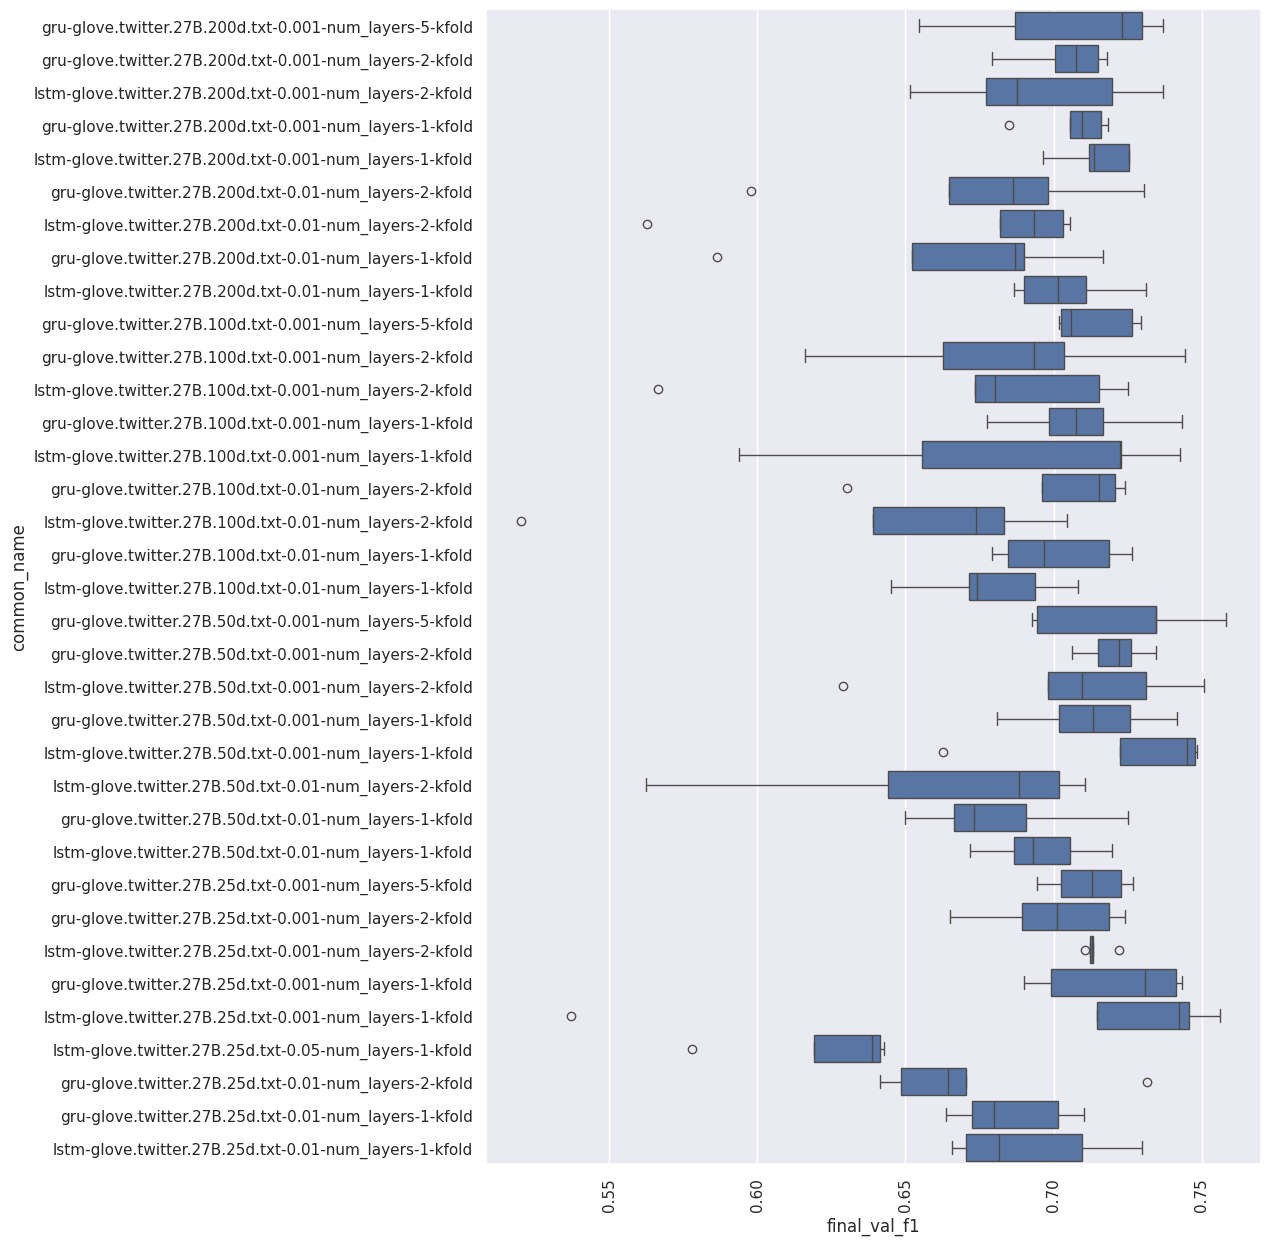

In [100]:
mean_threshold = 0.6  

grouped_means = runs_df.groupby('common_name')['final_val_f1'].mean().reset_index()


filtered_common_names = grouped_means[grouped_means['final_val_f1'] >= mean_threshold]['common_name']
filtered_df = runs_df[runs_df['common_name'].isin(filtered_common_names)]


sns.set(rc={"figure.figsize": (10, 15)})
palette = ['blue' if name == 'lstm-glove.twitter.27B.50d.txt-0.001-num_layers-1-kfold' else 'C0' for name in filtered_df['common_name']]

sns.boxplot(x='final_val_f1', y='common_name', data=filtered_df, orient='h', palette=palette)
plt.xticks(rotation=90)
plt.show()

# Final model training

In [134]:
embeddings_dictionary = {}
glove_embedding_path = "glove.twitter.27B.50d.txt"
with open("glove.twitter.27B.50d.txt") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
embedding_dim = find_digits(glove_embedding_path.split(".")[-2])
embedding_matrix = np.zeros((len(unique_words), embedding_dim))

config = {
                "epochs": 100,
                "learning_rate": 0.001,
                "optimizer": "Adam",
                "betas": (0.9, 0.999),
                "eps": 1e-08,
                "weight_decay": 0,
                "architecture": LSTMModel,
                "embedding": embedding_matrix
            }
embedding = config["embedding"]
architecture = config["architecture"]

epochs = config["epochs"]
learning_rate = config["learning_rate"]
betas = config["betas"]
eps = config["eps"]
weight_decay = config["weight_decay"]
model = architecture(embedding.shape[1],torch.tensor(embedding),num_layers=2).cuda()
 
with wandb.init(project="disaster-tweet", name="-".join([str(model), glove_embedding_path, str(config['learning_rate']), 'hidden-size-{str(1024}'])) as run:
    print("-".join([str(model), glove_embedding_path, str(learning_rate)]))
    data = pd.read_csv(f"../data/final_train_data.csv")
    X_train, X_test = train_test_split(data, random_state=42, stratify=data['target'], test_size=0.05)

    
    train_dataset = CustomDataset(X_train['text_lematized'].values.tolist(),X_train['target'].values.tolist())    
    test_dataset = CustomDataset(X_test['text'].values.tolist(), X_test['target'].values.tolist())    
    train_loader = DataLoader(train_dataset,batch_size= 16, shuffle = True,collate_fn=train_collate)
    val_loader = DataLoader(test_dataset,batch_size=32, shuffle=False, collate_fn=train_collate)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)
    for e in range(1, epochs + 1):
        # Training Phase
        model.train()
        num = 0
        total_batch = len(train_loader)
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader):
            num += 1
            logits = model(inputs.cuda())
            optimizer.zero_grad()
            loss = loss_func(logits.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            wandb.log({"batch_loss": loss.item()})  # Log loss of each batch

        mean_loss = epoch_loss / total_batch
        print("\repoch:%d %d/%d loss:" % (e, num, total_batch), loss.item(), end="")
        print(" mean loss:", mean_loss)
        wandb.log({"epoch": e, "epoch_loss": mean_loss})  # Log epoch loss
        wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})
    
        val_loss, accuracy, precision, recall, f1 = evaluate_model(model, val_loader, loss_func)
        print(f"\nValidation: loss: {val_loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1 score: {f1}")
        
        wandb.log({
            "val_loss": val_loss,
            "val_accuracy": accuracy,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1
        })
    wandb.log({
            "final_val_loss": val_loss,
            "final_val_accuracy": accuracy,
            "final_val_precision": precision,
            "final_val_recall": recall,
            "final_val_f1": f1
        })
    
    

lstm-glove.twitter.27B.50d.txt-0.001


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 219.30it/s]
/workspace/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch:1 258/258 loss: 0.6820850372314453 mean loss: 0.6933817969736202

Validation: loss: 0.6924778137888227, accuracy: 0.5161290322580645, precision: 0.26638917793964617, recall: 0.5161290322580645, f1 score: 0.3514070006863418


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 253.54it/s]


epoch:2 258/258 loss: 0.6356368064880371 mean loss: 0.6592917883580969

Validation: loss: 0.8706504276820591, accuracy: 0.6036866359447005, precision: 0.603354662496283, recall: 0.6036866359447005, f1 score: 0.6033153663990857


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.81it/s]


epoch:3 258/258 loss: 0.44565725326538086 mean loss: 0.635337900052699

Validation: loss: 0.8031174625669207, accuracy: 0.576036866359447, precision: 0.6408602150537634, recall: 0.576036866359447, f1 score: 0.532677000418936


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 268.64it/s]


epoch:4 258/258 loss: 0.3826046586036682 mean loss: 0.4554832530922668

Validation: loss: 0.6489546000957489, accuracy: 0.6589861751152074, precision: 0.6796805731593385, recall: 0.6589861751152074, f1 score: 0.6522335717665396


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 283.42it/s]


epoch:5 258/258 loss: 0.06481194496154785 mean loss: 0.26533006200956744

Validation: loss: 0.8023377060890198, accuracy: 0.6866359447004609, precision: 0.7099749480812372, recall: 0.6866359447004609, f1 score: 0.6804308497314148


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 250.09it/s]


epoch:6 258/258 loss: 0.03573894128203392 mean loss: 0.14985335418275852

Validation: loss: 0.5729684233665466, accuracy: 0.7096774193548387, precision: 0.710096675545033, recall: 0.7096774193548387, f1 score: 0.709751429317402


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.12it/s]


epoch:7 258/258 loss: 2.246919631958008 mean loss: 0.09617931300831974

Validation: loss: 0.6802927255630493, accuracy: 0.7096774193548387, precision: 0.7160441426146011, recall: 0.7096774193548387, f1 score: 0.7059907834101382


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.40it/s]


epoch:8 258/258 loss: 0.006084204185754061 mean loss: 0.07250907049738159

Validation: loss: 1.3181974717548914, accuracy: 0.631336405529954, precision: 0.672216441207076, recall: 0.631336405529954, f1 score: 0.6138159208237073


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 254.53it/s]


epoch:9 258/258 loss: 0.07379946857690811 mean loss: 0.04851486606256271

Validation: loss: 1.0308918271745955, accuracy: 0.6497695852534562, precision: 0.6514196622675069, recall: 0.6497695852534562, f1 score: 0.6497100829743624


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 258.82it/s]


epoch:10 258/258 loss: 0.004691711626946926 mean loss: 0.0363710020630902

Validation: loss: 0.8736160056931632, accuracy: 0.695852534562212, precision: 0.7022698400728576, recall: 0.695852534562212, f1 score: 0.6916567621407168


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.75it/s]


epoch:11 258/258 loss: 0.0016691569471731782 mean loss: 0.02719064882339173

Validation: loss: 1.0878251791000366, accuracy: 0.6543778801843319, precision: 0.6571080077974427, recall: 0.6543778801843319, f1 score: 0.6540548208239364


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.66it/s]


epoch:12 258/258 loss: 0.0010352733079344034 mean loss: 0.025913321284050224

Validation: loss: 1.0626571433884757, accuracy: 0.6682027649769585, precision: 0.6699093085047981, recall: 0.6682027649769585, f1 score: 0.6681463943967644


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 269.71it/s]


epoch:13 258/258 loss: 0.0012729407753795385 mean loss: 0.024822094953752507

Validation: loss: 1.8840090717588152, accuracy: 0.5345622119815668, precision: 0.640114110160193, recall: 0.5345622119815668, f1 score: 0.44569036996091127


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.01it/s]


epoch:14 258/258 loss: 0.0015216232277452946 mean loss: 0.031972835322322195

Validation: loss: 0.9607733147484916, accuracy: 0.695852534562212, precision: 0.7172592418177537, recall: 0.695852534562212, f1 score: 0.6906158357771262


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.95it/s]


epoch:15 258/258 loss: 0.0005025172140449286 mean loss: 0.021041674309774744

Validation: loss: 1.0270348957606725, accuracy: 0.6912442396313364, precision: 0.7042012492513049, recall: 0.6912442396313364, f1 score: 0.6882732123210424


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 250.53it/s]


epoch:16 258/258 loss: 0.0008567926124669611 mean loss: 0.01927941159977823

Validation: loss: 1.589861444064549, accuracy: 0.6359447004608295, precision: 0.663029880564874, recall: 0.6359447004608295, f1 score: 0.624896149581122


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 245.10it/s]


epoch:17 258/258 loss: 0.001088002696633339 mean loss: 0.016116341232148886

Validation: loss: 1.060497794832502, accuracy: 0.6359447004608295, precision: 0.6495466700697833, recall: 0.6359447004608295, f1 score: 0.6309609587784779


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 244.72it/s]


epoch:18 258/258 loss: 0.0010687033645808697 mean loss: 0.02014953304802306

Validation: loss: 1.2346997090748377, accuracy: 0.663594470046083, precision: 0.6752374433130829, recall: 0.663594470046083, f1 score: 0.6603573805885984


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 249.21it/s]


epoch:19 258/258 loss: 0.0005853173788636923 mean loss: 0.015790848912673013

Validation: loss: 0.9070826428277152, accuracy: 0.6497695852534562, precision: 0.6537582775045502, recall: 0.6497695852534562, f1 score: 0.6490399385560676


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 245.15it/s]


epoch:20 258/258 loss: 0.0003921198658645153 mean loss: 0.012852114488329205

Validation: loss: 0.9688548956598554, accuracy: 0.6728110599078341, precision: 0.6815550041356492, recall: 0.6728110599078341, f1 score: 0.6707597185906418


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 242.02it/s]


epoch:21 258/258 loss: 0.0003003026940859854 mean loss: 0.010464531532060102

Validation: loss: 1.3561304722513472, accuracy: 0.6359447004608295, precision: 0.6760229018293534, recall: 0.6359447004608295, f1 score: 0.6194146219952672


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.95it/s]


epoch:22 258/258 loss: 0.0005217482103034854 mean loss: 0.010089234622915513

Validation: loss: 0.9869215914181301, accuracy: 0.6451612903225806, precision: 0.6563774564330738, recall: 0.6451612903225806, f1 score: 0.6348645791006546


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 247.68it/s]


epoch:23 258/258 loss: 0.00026025791885331273 mean loss: 0.010448674992734906

Validation: loss: 1.2104157890592302, accuracy: 0.6682027649769585, precision: 0.6897786981333048, recall: 0.6682027649769585, f1 score: 0.661632664421498


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 242.96it/s]


epoch:24 258/258 loss: 0.00017486466094851494 mean loss: 0.008858881018504901

Validation: loss: 1.159353426524571, accuracy: 0.6451612903225806, precision: 0.6648811406282944, recall: 0.6451612903225806, f1 score: 0.6295685119225547


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 250.90it/s]


epoch:25 258/258 loss: 0.00019828327640425414 mean loss: 0.009860928794366845

Validation: loss: 1.064958427633558, accuracy: 0.6589861751152074, precision: 0.6635439205062909, recall: 0.6589861751152074, f1 score: 0.6542818242183794


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 248.95it/s]


epoch:26 258/258 loss: 0.000380619487259537 mean loss: 0.010888414035434835

Validation: loss: 1.4150003790855408, accuracy: 0.663594470046083, precision: 0.6887142208087234, recall: 0.663594470046083, f1 score: 0.655510074665173


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 248.04it/s]


epoch:27 258/258 loss: 0.00011669883679132909 mean loss: 0.011228704806938388

Validation: loss: 1.2577269077301025, accuracy: 0.6451612903225806, precision: 0.6736134882649853, recall: 0.6451612903225806, f1 score: 0.6343924495917265


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 290.69it/s]


epoch:28 258/258 loss: 0.00017605606990400702 mean loss: 0.008784821286155434

Validation: loss: 1.3695602416992188, accuracy: 0.6543778801843319, precision: 0.6673193030878041, recall: 0.6543778801843319, f1 score: 0.6503804515673028


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 266.19it/s]


epoch:29 258/258 loss: 0.0006165295490063727 mean loss: 0.01066779590592189

Validation: loss: 1.233537461076464, accuracy: 0.6497695852534562, precision: 0.652091411599703, recall: 0.6497695852534562, f1 score: 0.6495464137912134


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 292.73it/s]


epoch:30 258/258 loss: 0.0010743498569354415 mean loss: 0.01383069135752789

Validation: loss: 1.1358447245189123, accuracy: 0.6129032258064516, precision: 0.6125552959888664, recall: 0.6129032258064516, f1 score: 0.6122597145450045


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 283.76it/s]


epoch:31 258/258 loss: 0.007306993938982487 mean loss: 0.04070560179541136

Validation: loss: 0.7354477729116168, accuracy: 0.6359447004608295, precision: 0.6381519043883108, recall: 0.6359447004608295, f1 score: 0.6320698525093428


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 294.57it/s]


epoch:32 258/258 loss: 0.0025957601610571146 mean loss: 0.024874685890792125

Validation: loss: 0.811728869165693, accuracy: 0.6129032258064516, precision: 0.6296085370649094, recall: 0.6129032258064516, f1 score: 0.5933778445510497


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 296.39it/s]


epoch:33 258/258 loss: 0.0012459720019251108 mean loss: 0.011052416614865949

Validation: loss: 1.0400157485689436, accuracy: 0.6589861751152074, precision: 0.6822237474262183, recall: 0.6589861751152074, f1 score: 0.6512881463749436


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 270.68it/s]


epoch:34 258/258 loss: 9.250210860045627e-05 mean loss: 0.008758879496520584

Validation: loss: 1.2269069126674108, accuracy: 0.6543778801843319, precision: 0.6784249583522641, recall: 0.6543778801843319, f1 score: 0.6460719945190133


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.22it/s]


epoch:35 258/258 loss: 0.00022866780636832118 mean loss: 0.009623104149936843

Validation: loss: 1.0175588130950928, accuracy: 0.6036866359447005, precision: 0.6076246334310851, recall: 0.6036866359447005, f1 score: 0.5952184016700146


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 243.59it/s]


epoch:36 258/258 loss: 0.00015787957818247378 mean loss: 0.00841336474887478

Validation: loss: 1.3493321112224035, accuracy: 0.5806451612903226, precision: 0.6001931620629708, recall: 0.5806451612903226, f1 score: 0.5475777546537172


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 241.54it/s]


epoch:37 258/258 loss: 5.9543250245042145e-05 mean loss: 0.008322938460490734

Validation: loss: 1.381180771759578, accuracy: 0.6082949308755761, precision: 0.6272483052448213, recall: 0.6082949308755761, f1 score: 0.5857891589008904


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 250.36it/s]


epoch:38 258/258 loss: 0.00025650422321632504 mean loss: 0.010562462682533214

Validation: loss: 1.1111067022596086, accuracy: 0.6405529953917051, precision: 0.6425772225549755, recall: 0.6405529953917051, f1 score: 0.6370717808584376


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 242.49it/s]


epoch:39 258/258 loss: 0.00011169187928317115 mean loss: 0.008294039525597242

Validation: loss: 1.401016184261867, accuracy: 0.6129032258064516, precision: 0.6257019720517174, recall: 0.6129032258064516, f1 score: 0.5966879420389857


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 251.49it/s]


epoch:40 258/258 loss: 2.783497257041745e-05 mean loss: 0.007834687128043987

Validation: loss: 1.4603406957217626, accuracy: 0.6129032258064516, precision: 0.6224555551343771, recall: 0.6129032258064516, f1 score: 0.5996577393685292


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 248.75it/s]


epoch:41 258/258 loss: 6.300012319115922e-05 mean loss: 0.007782127962248826

Validation: loss: 1.4060362236840385, accuracy: 0.663594470046083, precision: 0.6663894976816925, recall: 0.663594470046083, f1 score: 0.6632800256019649


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 249.66it/s]


epoch:42 258/258 loss: 5.394074833020568e-05 mean loss: 0.007654927314856756

Validation: loss: 1.4336297426904951, accuracy: 0.6405529953917051, precision: 0.6414195123872543, recall: 0.6405529953917051, f1 score: 0.6382875730937536


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.83it/s]


epoch:43 258/258 loss: 3.337804082548246e-05 mean loss: 0.007713782301559763

Validation: loss: 1.4776598726000105, accuracy: 0.6543778801843319, precision: 0.6604220626324464, recall: 0.6543778801843319, f1 score: 0.6483755422737157


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 248.61it/s]


epoch:44 258/258 loss: 3.6894525692332536e-05 mean loss: 0.00770465718811155

Validation: loss: 1.4787751265934534, accuracy: 0.6267281105990783, precision: 0.6344096182805862, recall: 0.6267281105990783, f1 score: 0.6170947600521556


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 252.23it/s]


epoch:45 258/258 loss: 3.45700973412022e-05 mean loss: 0.007564425305229302

Validation: loss: 1.4170761023248946, accuracy: 0.6175115207373272, precision: 0.6302072206793421, recall: 0.6175115207373272, f1 score: 0.6022538254135277


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.52it/s]


epoch:46 258/258 loss: 2.25302701437613e-05 mean loss: 0.0072721339731443135

Validation: loss: 1.593118463243757, accuracy: 0.6359447004608295, precision: 0.6448299882203697, recall: 0.6359447004608295, f1 score: 0.6330840605225293


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 246.79it/s]


epoch:47 258/258 loss: 0.0012877495028078556 mean loss: 0.01967709357147616

Validation: loss: 0.9392022745949882, accuracy: 0.5990783410138248, precision: 0.6527361819193283, recall: 0.5990783410138248, f1 score: 0.5691814369162888


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 258.13it/s]


epoch:48 258/258 loss: 0.00021586459479294717 mean loss: 0.02376640408605341

Validation: loss: 0.8460303459848676, accuracy: 0.663594470046083, precision: 0.6635751074623397, recall: 0.663594470046083, f1 score: 0.6628914281862002


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 263.35it/s]


epoch:49 258/258 loss: 3.808657857007347e-05 mean loss: 0.013009342733065461

Validation: loss: 0.997575751372746, accuracy: 0.6728110599078341, precision: 0.673664592868693, recall: 0.6728110599078341, f1 score: 0.6728805489043495


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 268.12it/s]


epoch:50 258/258 loss: 0.0007235172670334578 mean loss: 0.00851821501969108

Validation: loss: 1.0381930215018136, accuracy: 0.6451612903225806, precision: 0.650602577305241, recall: 0.6451612903225806, f1 score: 0.6438775307055392


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 287.77it/s]


epoch:51 258/258 loss: 9.786218288354576e-05 mean loss: 0.008100978585184925

Validation: loss: 1.1077512332371302, accuracy: 0.6589861751152074, precision: 0.6592430180612272, recall: 0.6589861751152074, f1 score: 0.6590586325826738


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 262.05it/s]


epoch:52 258/258 loss: 0.00010721800208557397 mean loss: 0.007585800207140377

Validation: loss: 1.1591053094182695, accuracy: 0.663594470046083, precision: 0.6638229805385231, recall: 0.663594470046083, f1 score: 0.6625601054674021


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 253.43it/s]


epoch:53 258/258 loss: 4.237753455527127e-05 mean loss: 0.007483964833354125

Validation: loss: 1.1964988027300154, accuracy: 0.6221198156682027, precision: 0.6299896892031227, recall: 0.6221198156682027, f1 score: 0.6117705690467561


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.80it/s]


epoch:54 258/258 loss: 2.348384805372916e-05 mean loss: 0.007428481031617361

Validation: loss: 1.2314126236098153, accuracy: 0.631336405529954, precision: 0.6402022880149262, recall: 0.631336405529954, f1 score: 0.6212395795578108


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 257.09it/s]


epoch:55 258/258 loss: 2.074217081826646e-05 mean loss: 0.007401713343528553

Validation: loss: 1.248945721558162, accuracy: 0.6589861751152074, precision: 0.6608825661471548, recall: 0.6589861751152074, f1 score: 0.6562908768429221


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 297.17it/s]


epoch:56 258/258 loss: 1.6569874787819572e-05 mean loss: 0.0073751494203107126

Validation: loss: 1.2294200573648726, accuracy: 0.6543778801843319, precision: 0.6545171287656625, recall: 0.6543778801843319, f1 score: 0.6533151768500706


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 293.40it/s]


epoch:57 258/258 loss: 2.133813723048661e-05 mean loss: 0.007358416427701008

Validation: loss: 1.305405114378248, accuracy: 0.6451612903225806, precision: 0.6495177317364572, recall: 0.6451612903225806, f1 score: 0.6398604890565341


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 301.40it/s]


epoch:58 258/258 loss: 9.298279110225849e-06 mean loss: 0.007563064449235993

Validation: loss: 1.2529258728027344, accuracy: 0.6267281105990783, precision: 0.6344096182805862, recall: 0.6267281105990783, f1 score: 0.6170947600521556


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 268.45it/s]


epoch:59 258/258 loss: 1.549703119962942e-05 mean loss: 0.007347696752780633

Validation: loss: 1.2661694288253784, accuracy: 0.6497695852534562, precision: 0.6495556118459453, recall: 0.6497695852534562, f1 score: 0.6494414865852385


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 257.84it/s]


epoch:60 258/258 loss: 7.808170266798697e-06 mean loss: 0.0074884093342394735

Validation: loss: 1.3113488895552499, accuracy: 0.631336405529954, precision: 0.6388005452067241, recall: 0.631336405529954, f1 score: 0.6223859114384896


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 264.25it/s]


epoch:61 258/258 loss: 1.6271840650006197e-05 mean loss: 0.007115164033183991

Validation: loss: 1.3494615299361092, accuracy: 0.6221198156682027, precision: 0.6242884250474383, recall: 0.6221198156682027, f1 score: 0.6218790254063091


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 263.97it/s]


epoch:62 258/258 loss: 6.496872174466262e-06 mean loss: 0.007393972928362688

Validation: loss: 1.317120441368648, accuracy: 0.6267281105990783, precision: 0.630974805745232, recall: 0.6267281105990783, f1 score: 0.6202455856556129


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 265.33it/s]


epoch:63 258/258 loss: 1.0669175026123412e-05 mean loss: 0.007263333740784994

Validation: loss: 1.3925025292805262, accuracy: 0.631336405529954, precision: 0.6388005452067241, recall: 0.631336405529954, f1 score: 0.6223859114384896


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 262.92it/s]


epoch:64 258/258 loss: 7.867763088142965e-06 mean loss: 0.007468299323208573

Validation: loss: 2.3315958976745605, accuracy: 0.6497695852534562, precision: 0.6644554793222396, recall: 0.6497695852534562, f1 score: 0.6377855737143835


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 258.12it/s]


epoch:65 258/258 loss: 0.0005465898429974914 mean loss: 0.04046130578677731

Validation: loss: 1.24579633133752, accuracy: 0.6359447004608295, precision: 0.643165480619875, recall: 0.6359447004608295, f1 score: 0.6276448788130036


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 267.37it/s]


epoch:66 258/258 loss: 0.017770476639270782 mean loss: 0.0218975428186579

Validation: loss: 0.9489670140402657, accuracy: 0.6728110599078341, precision: 0.6756709875659423, recall: 0.6728110599078341, f1 score: 0.6725052303799931


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 262.03it/s]


epoch:67 258/258 loss: 0.00031000515446066856 mean loss: 0.012303055752898556

Validation: loss: 0.9392900552068438, accuracy: 0.6451612903225806, precision: 0.6485568760611206, recall: 0.6451612903225806, f1 score: 0.6406554019457245


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 276.58it/s]


epoch:68 258/258 loss: 0.00024081568699330091 mean loss: 0.009420919612450741

Validation: loss: 1.1468454429081507, accuracy: 0.663594470046083, precision: 0.663708443684098, recall: 0.663594470046083, f1 score: 0.6636373670596575


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 297.48it/s]


epoch:69 258/258 loss: 0.00011014254414476454 mean loss: 0.00952585289119869

Validation: loss: 1.0927982585770744, accuracy: 0.6589861751152074, precision: 0.6593281193464888, recall: 0.6589861751152074, f1 score: 0.6577474496829335


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 294.78it/s]


epoch:70 258/258 loss: 0.00030536617850884795 mean loss: 0.0083163038837857

Validation: loss: 1.1152648414884294, accuracy: 0.6497695852534562, precision: 0.6549300723873779, recall: 0.6497695852534562, f1 score: 0.644120707596254


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 291.15it/s]


epoch:71 258/258 loss: 6.32981100352481e-05 mean loss: 0.008060858501915553

Validation: loss: 1.2037474087306432, accuracy: 0.6451612903225806, precision: 0.6547057998670901, recall: 0.6451612903225806, f1 score: 0.6360036607903207


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 243.50it/s]


epoch:72 258/258 loss: 5.2152703574392945e-05 mean loss: 0.007891472447283391

Validation: loss: 1.2703153150422233, accuracy: 0.6497695852534562, precision: 0.6574780058651027, recall: 0.6497695852534562, f1 score: 0.6422860293828035


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 249.73it/s]


epoch:73 258/258 loss: 5.268909444566816e-05 mean loss: 0.007917514969421056

Validation: loss: 1.1328458275113786, accuracy: 0.631336405529954, precision: 0.6402022880149262, recall: 0.631336405529954, f1 score: 0.6212395795578108


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 270.88it/s]


epoch:74 258/258 loss: 2.8848065994679928e-05 mean loss: 0.007651871440874285

Validation: loss: 1.2076699052538191, accuracy: 0.663594470046083, precision: 0.663418859830047, recall: 0.663594470046083, f1 score: 0.6633796928450654


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.91it/s]


epoch:75 258/258 loss: 4.4881242502015084e-05 mean loss: 0.007809987681267635

Validation: loss: 1.304037630558014, accuracy: 0.6405529953917051, precision: 0.6539554982752739, recall: 0.6405529953917051, f1 score: 0.6282536151279199


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 258.73it/s]


epoch:76 258/258 loss: 3.528528759488836e-05 mean loss: 0.007463503457673973

Validation: loss: 1.3235659343855721, accuracy: 0.631336405529954, precision: 0.6434555172283082, recall: 0.631336405529954, f1 score: 0.6187216565414563


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 253.23it/s]


epoch:77 258/258 loss: 3.4272052289452404e-05 mean loss: 0.007757366944634111

Validation: loss: 1.3143383009093148, accuracy: 0.5944700460829493, precision: 0.6108658743633277, recall: 0.5944700460829493, f1 score: 0.5701735891489212


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 260.54it/s]


epoch:78 258/258 loss: 2.622568717924878e-05 mean loss: 0.007899898162492697

Validation: loss: 1.4375654373850142, accuracy: 0.6036866359447005, precision: 0.6133397528486599, recall: 0.6036866359447005, f1 score: 0.5886481162275301


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 260.51it/s]


epoch:79 258/258 loss: 4.398655437398702e-05 mean loss: 0.007889303340336426

Validation: loss: 1.5554950407573156, accuracy: 0.663594470046083, precision: 0.6638229805385231, recall: 0.663594470046083, f1 score: 0.6625601054674021


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 249.61it/s]


epoch:80 258/258 loss: 4.1006700485013425e-05 mean loss: 0.007527069789350997

Validation: loss: 1.4229423659188407, accuracy: 0.6221198156682027, precision: 0.6265378947929057, recall: 0.6221198156682027, f1 score: 0.6150715287517532


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 262.01it/s]


epoch:81 258/258 loss: 3.433166421018541e-05 mean loss: 0.007296372929688865

Validation: loss: 1.3982716458184379, accuracy: 0.6589861751152074, precision: 0.6613590737837912, recall: 0.6589861751152074, f1 score: 0.6587688765861814


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 262.91it/s]


epoch:82 258/258 loss: 4.4105694541940466e-05 mean loss: 0.008833441291667547

Validation: loss: 1.3816522359848022, accuracy: 0.6129032258064516, precision: 0.6224555551343771, recall: 0.6129032258064516, f1 score: 0.5996577393685292


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 257.22it/s]


epoch:83 258/258 loss: 3.307986480649561e-05 mean loss: 0.010694662526426087

Validation: loss: 1.3824794462748937, accuracy: 0.6405529953917051, precision: 0.6504148868267295, recall: 0.6405529953917051, f1 score: 0.6307085900688655


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 264.17it/s]


epoch:84 258/258 loss: 3.0397888622246683e-05 mean loss: 0.011822545017652331

Validation: loss: 1.3464445216315133, accuracy: 0.6082949308755761, precision: 0.6089988406192458, recall: 0.6082949308755761, f1 score: 0.604858995369314


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 257.50it/s]


epoch:85 258/258 loss: 4.213956344756298e-05 mean loss: 0.014382748661315531

Validation: loss: 1.2062167865889413, accuracy: 0.6451612903225806, precision: 0.6454988812070689, recall: 0.6451612903225806, f1 score: 0.6436589260647781


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 264.07it/s]


epoch:86 258/258 loss: 0.0013059908524155617 mean loss: 0.010325543460553033

Validation: loss: 1.1703171389443534, accuracy: 0.6405529953917051, precision: 0.6425772225549755, recall: 0.6405529953917051, f1 score: 0.6370717808584376


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 263.49it/s]


epoch:87 258/258 loss: 0.00016770753427408636 mean loss: 0.01221661195558572

Validation: loss: 0.9500270315579006, accuracy: 0.6221198156682027, precision: 0.6639347571561226, recall: 0.6221198156682027, f1 score: 0.5888842731399536


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.79it/s]


epoch:88 258/258 loss: 9.482564928475767e-05 mean loss: 0.00841698119727725

Validation: loss: 1.1542946355683463, accuracy: 0.6082949308755761, precision: 0.6420356938347012, recall: 0.6082949308755761, f1 score: 0.5750583553361649


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.15it/s]


epoch:89 258/258 loss: 2.789442442008294e-05 mean loss: 0.007819697620085884

Validation: loss: 1.3551197733197893, accuracy: 0.6175115207373272, precision: 0.6642271116912176, recall: 0.6175115207373272, f1 score: 0.5801498767485938


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 247.67it/s]


epoch:90 258/258 loss: 4.452361463336274e-05 mean loss: 0.008006212353287738

Validation: loss: 1.1415700231279646, accuracy: 0.6036866359447005, precision: 0.6411602900725183, recall: 0.6036866359447005, f1 score: 0.5662880508859609


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 261.74it/s]


epoch:91 258/258 loss: 2.741775824688375e-05 mean loss: 0.007547481645596863

Validation: loss: 1.2821553775242396, accuracy: 0.6036866359447005, precision: 0.6502396109005077, recall: 0.6036866359447005, f1 score: 0.5608582510924534


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 271.42it/s]


epoch:92 258/258 loss: 2.545084134908393e-05 mean loss: 0.007271268621797241

Validation: loss: 1.2158776691981725, accuracy: 0.6036866359447005, precision: 0.6411602900725183, recall: 0.6036866359447005, f1 score: 0.5662880508859609


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.91it/s]


epoch:93 258/258 loss: 1.62718934006989e-05 mean loss: 0.007647252651249025

Validation: loss: 1.317468421799796, accuracy: 0.6036866359447005, precision: 0.6454630899104087, recall: 0.6036866359447005, f1 score: 0.5636320958901604


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 260.54it/s]


epoch:94 258/258 loss: 1.6987178241834044e-05 mean loss: 0.007317888572020298

Validation: loss: 1.2808525221688407, accuracy: 0.6082949308755761, precision: 0.6459363696759429, recall: 0.6082949308755761, f1 score: 0.5726012154993912


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.04it/s]


epoch:95 258/258 loss: 1.716598853818141e-05 mean loss: 0.007279551850536145

Validation: loss: 1.1882826941353934, accuracy: 0.6774193548387096, precision: 0.68572798125233, recall: 0.6774193548387096, f1 score: 0.6714025245441795


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.43it/s]


epoch:96 258/258 loss: 9.77509898802964e-06 mean loss: 0.007453192209229109

Validation: loss: 1.3275777101516724, accuracy: 0.6036866359447005, precision: 0.6411602900725183, recall: 0.6036866359447005, f1 score: 0.5662880508859609


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.28it/s]


epoch:97 258/258 loss: 0.000312713033054024 mean loss: 0.009072484931553746

Validation: loss: 1.235062565122332, accuracy: 0.5990783410138248, precision: 0.6405529953917051, recall: 0.5990783410138248, f1 score: 0.5571701536633537


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 245.69it/s]


epoch:98 258/258 loss: 1.6867968952283263e-05 mean loss: 0.00777521418742197

Validation: loss: 1.1494777032307215, accuracy: 0.6543778801843319, precision: 0.6708193777619297, recall: 0.6543778801843319, f1 score: 0.6419164089407842


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 256.03it/s]


epoch:99 258/258 loss: 1.2516897186287679e-05 mean loss: 0.00738871326653722

Validation: loss: 1.3868308748517717, accuracy: 0.6082949308755761, precision: 0.650246639431797, recall: 0.6082949308755761, f1 score: 0.5700330063088007


100%|████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 280.78it/s]


epoch:100 258/258 loss: 1.5258658095262945e-05 mean loss: 0.007293194944035942

Validation: loss: 1.437525817326137, accuracy: 0.6036866359447005, precision: 0.6411602900725183, recall: 0.6036866359447005, f1 score: 0.5662880508859609


batch_loss,█▇▂▄▃▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_val_accuracy,▁
final_val_f1,▁
final_val_loss,▁
final_val_precision,▁
final_val_recall,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃█▅▆▂▅▆▅▇▆▆▅▆▃▅▆▅▅▇▆▅▆▆▅▆▆▆▆▆▄▆▅▄▅▅▄▄▄▄
val_f1,▁▅█▆▇▃▆▇▆▇▇▇▆▇▅▆▇▆▇▇▇▆▇▇▆▇▇▇▇▇▅▇▆▆▆▅▅▅▅▅


The final training spanned 5 epochs. It appears that additional epochs do not improve performance. The peak F1 score was achieved between 5 and 8 epochs. Beyond that, the validation loss did not improve, and the model began to overfit slightly.

In [139]:
run = api.run("disaster-tweet/dnik1wtc")

df = run.history()

08-17 17:48 urllib3.connectionpool DEBUG    https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None


In [140]:
def plot_run(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['_step'], y=df['batch_loss'], label='Batch Loss', marker='o')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Batch Loss per Step')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['_step'], y=df['val_f1'], label='Validation F1 Score', marker='o', color='orange')
    plt.xlabel('Step')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score per Step')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['_step'], y=df['val_loss'], label='Validation Loss', marker='o', color='red')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['_step'], y=df['batch_loss'], label='Batch Loss', marker='o')
    sns.lineplot(x=df['_step'], y=df['val_f1'], label='Validation F1 Score', marker='o', color='orange')
    sns.lineplot(x=df['_step'], y=df['val_loss'], label='Validation Loss', marker='o', color='green')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Batch Loss, Validation F1 Score, and Validation Loss per Step')
    plt.legend()
    plt.grid(True)
    plt.show()

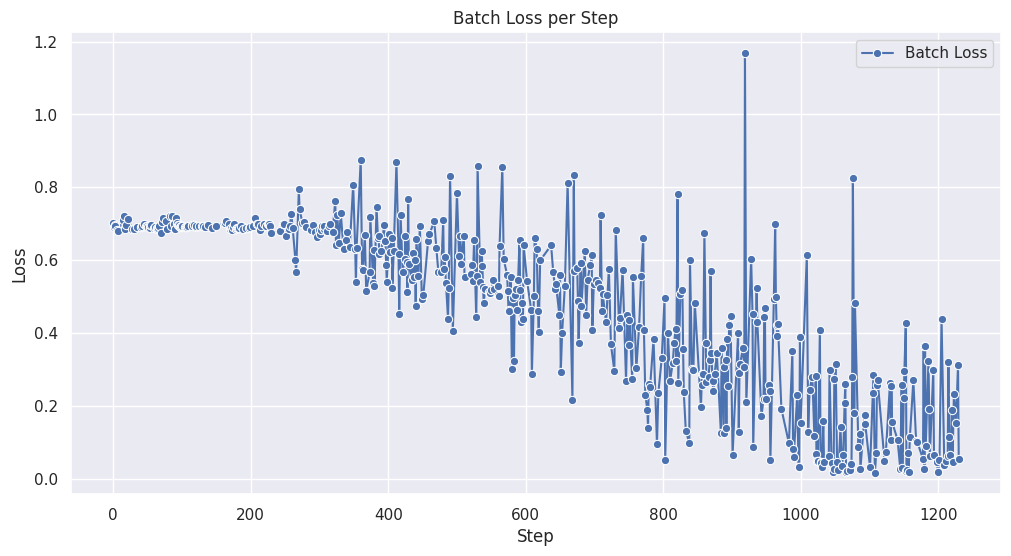

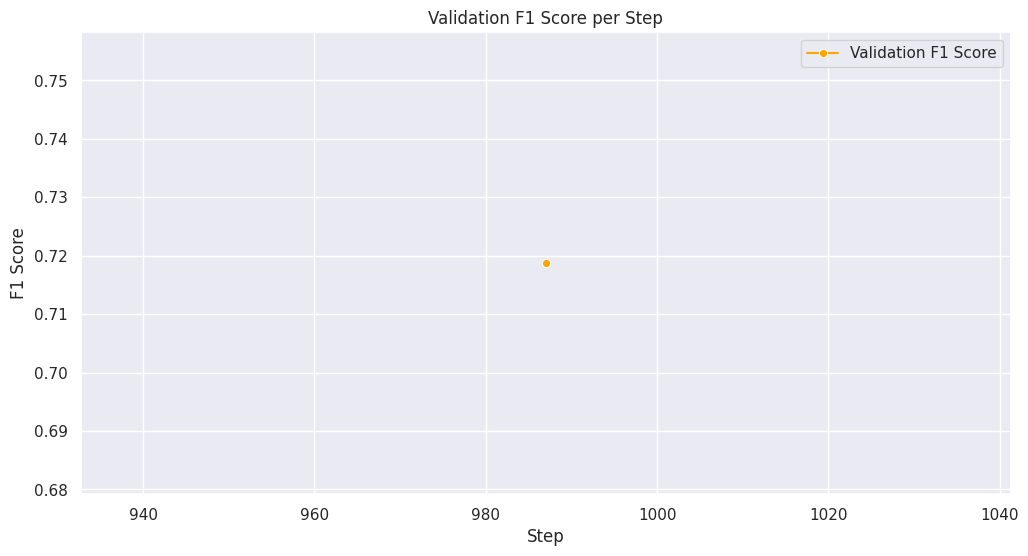

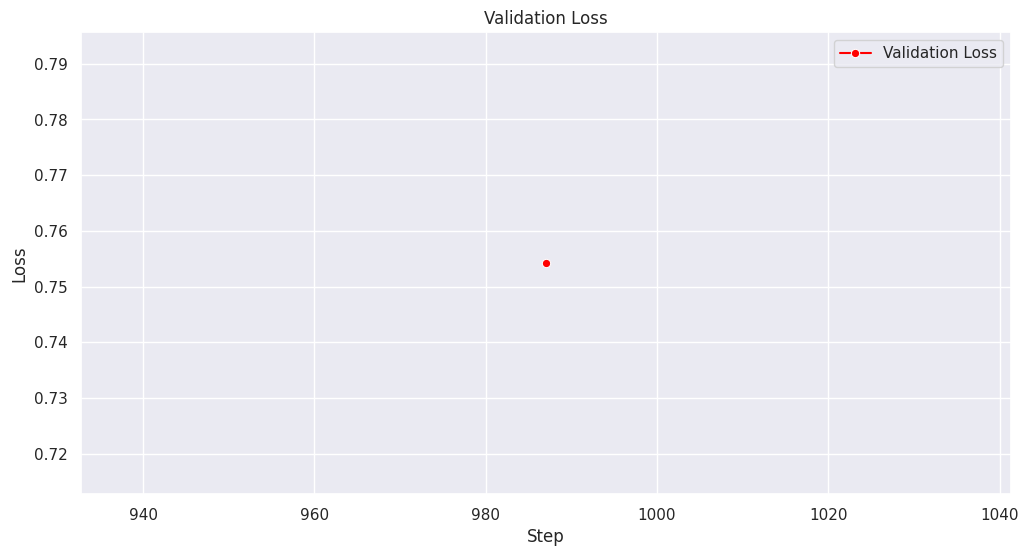

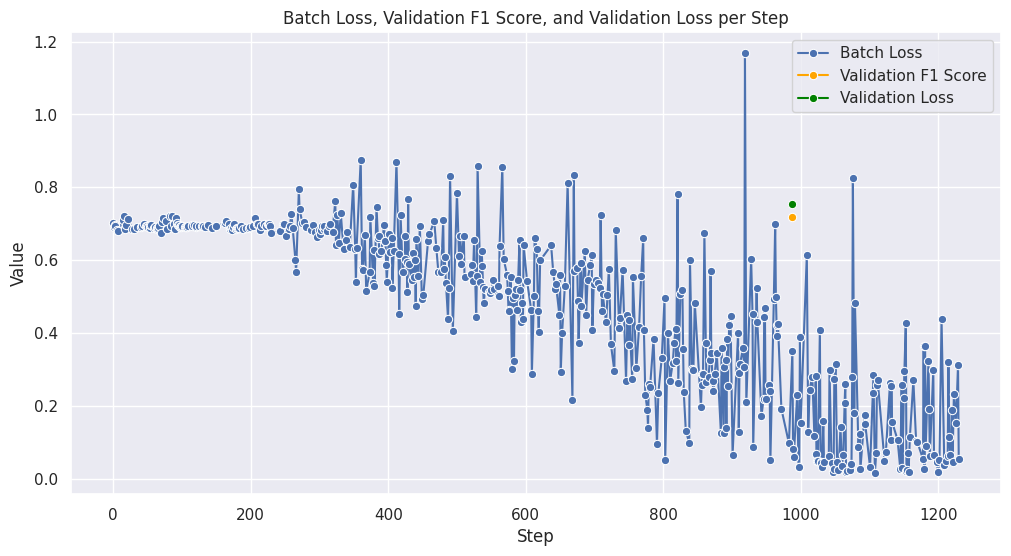

In [141]:
plot_run(df)

08-17 17:48 urllib3.connectionpool DEBUG    https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None


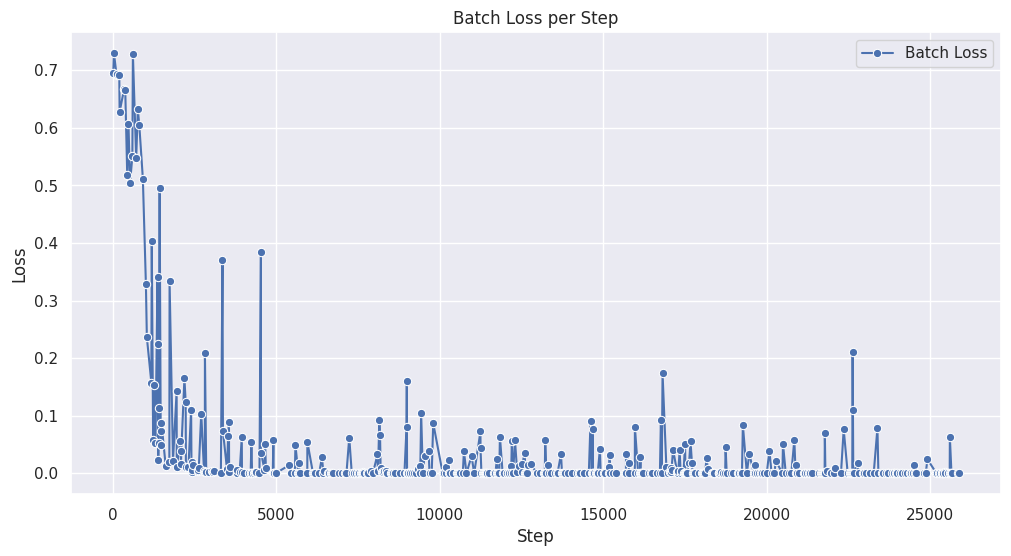

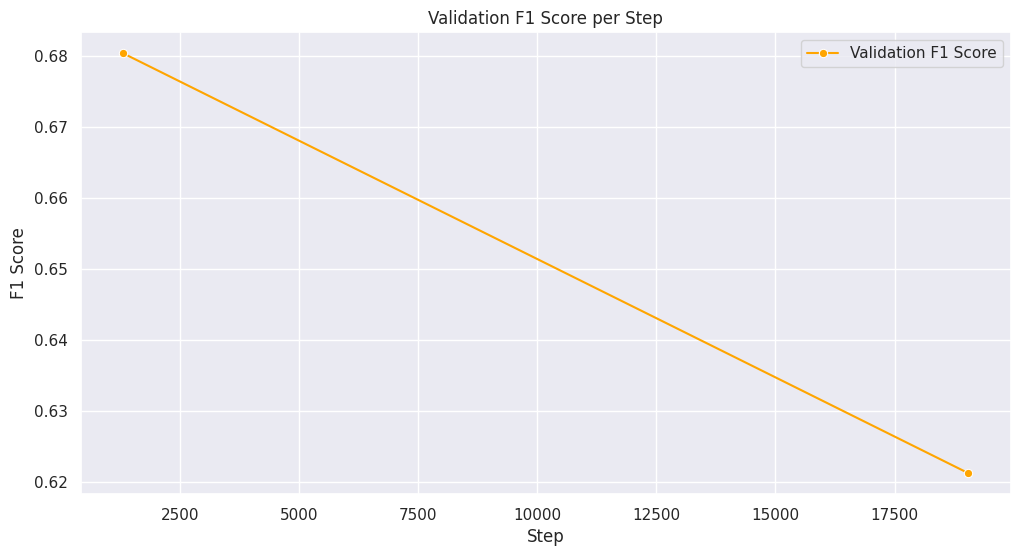

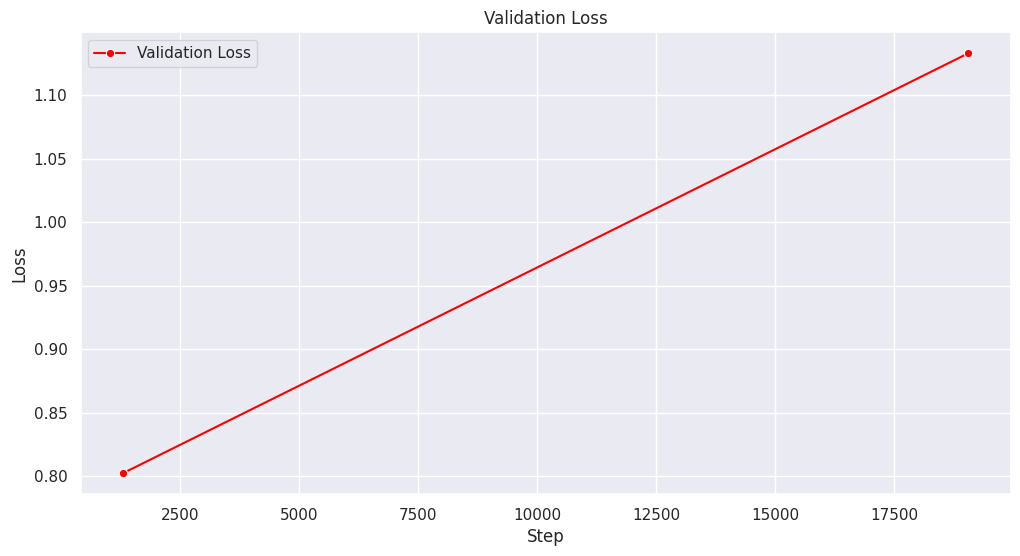

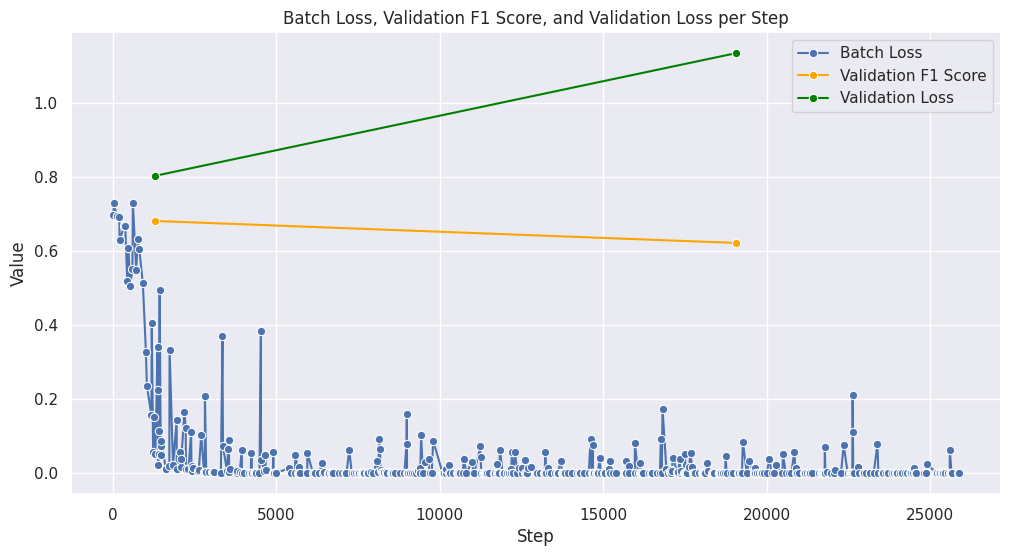

In [142]:
run = api.run("disaster-tweet/klo1x46m")

df = run.history()
plot_run(df)

# Preprocessing test data and saving to the expected format

Now we can preprocess all the test data to prepare for submission.

In [ ]:
data = pd.read_csv(f"../data/test.csv")


In [ ]:
data_cleaner = DataCleaner(data)
data_cleaner.preprocess()

In [ ]:
data_cleaner.data.to_csv("../data//_test_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_test_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="test_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_test_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

In [ ]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

In [ ]:
data['text'] = new_texts

In [ ]:
valid_dataset = CustomDataset(data['text'])  
valid_loader = DataLoader(valid_dataset,batch_size=10,shuffle=False,collate_fn=lambda texts:texts2tensor(texts,WORD2IX))

In [ ]:
def predict(model, val_loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs in val_loader:
            logits = model(inputs.cuda())
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

In [ ]:
preds = predict(model, valid_loader)

In [ ]:
data['target'] = preds

In [ ]:
data[['id', 'target']].to_csv("../data/sub.csv", index=False)

# Discussion and Conclusion

Training and validation metrics were measured using the F1 score because we aimed to increase the probability of accurately identifying both positive and negative samples related to disasters.

The LSTM model was selected due to its robust performance during cross-validation. Better results could potentially be achieved through the following approaches:

- Using transformers and leveraging transfer learning.
- Improving data preprocessing, such as retaining specific Named Entity Recognitions (NERs).
- Clustering documents and applying separate models for each cluster.
- Extending the training period and conducting more extensive hyperparameter optimization.
- Adjusting the probability threshold used by the model.

# Source

1. https://stats.stackexchange.com/questions/389865/how-to-distinguish-overfitting-and-underfitting-from-the-roc-auc-curve
2. https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6
3. https://nlp.stanford.edu/projects/glove/
4. https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/
5. https://www.deeplearningbook.org/contents/rnn.html
6. https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce
7. https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
8. https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
9. https://d2l.ai/chapter_recurrent-neural-networks/index.html
10. https://cs224d.stanford.edu/reports/Lambert.pdf
11. https://stats.stackexchange.com/questions/585860/stacked-rnn-to-overcome-vanishing-gradient